* [U Wyoming](http://weather.uwyo.edu/upperair/sounding.html)
* [潮岬](http://weather.uwyo.edu/cgi-bin/sounding?region=seasia&TYPE=TEXT%3ALIST&YEAR=2018&MONTH=09&FROM=0400&TO=0612&STNM=47778)

In [12]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import io
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [2]:
url = "http://weather.uwyo.edu/cgi-bin/sounding?region=seasia&TYPE=TEXT%3ALIST&YEAR=2018&MONTH=09&FROM=0400&TO=0612&STNM=47778"
response = urlopen(url)
html = response.read().decode("utf8")
soup = BeautifulSoup(html, "html.parser")

In [3]:
s = soup.pre.string

In [4]:
f = io.StringIO(s)

In [5]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

In [6]:
df = pd.read_fwf(f, skiprows=5, skipfooter=1,
                  usecols=[0, 1, 2, 3, 6, 7], names=col_names)

In [7]:
df

,pressure,height,temperature,dewpoint,direction,speed
0,1000.0,8,NaN,NaN,NaN,NaN
1,990.0,75,27.4,24.7,120.0,24.0
2,972.0,236,26.1,23.8,125.0,47.0
3,925.0,671,22.6,21.4,145.0,54.0
4,850.0,1405,17.8,17.3,155.0,66.0
5,775.0,2192,13.2,12.4,163.0,72.0
6,754.0,2422,12.4,10.9,165.0,74.0
7,700.0,3046,10.4,6.9,165.0,74.0
8,696.0,3094,10.4,5.5,165.0,74.0
9,654.0,3608,6.2,2.1,165.0,78.0


In [13]:
df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['speed'], np.deg2rad(df['direction']))
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                       'u_wind', 'v_wind'), how='all').reset_index(drop=True)

In [15]:
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

In [16]:
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
print(lcl_pressure, lcl_temperature)

951.8403007544475 hectopascal 24.04446396516281 degC


In [17]:
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

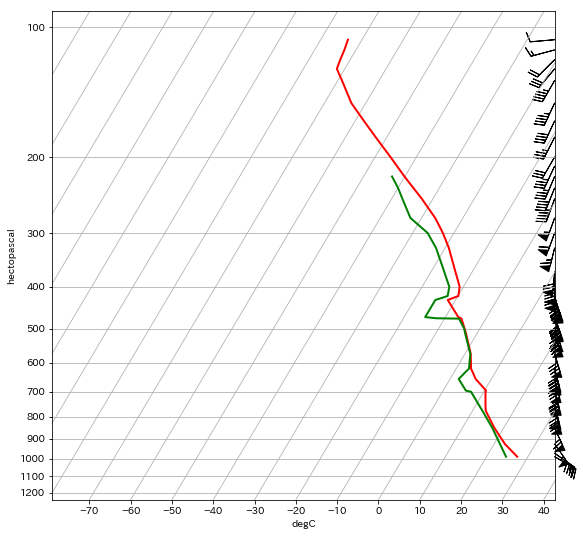

In [18]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

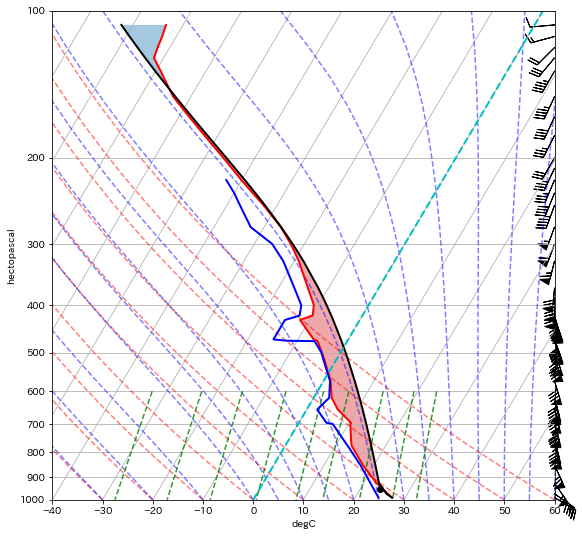

In [19]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'b', linewidth=2)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

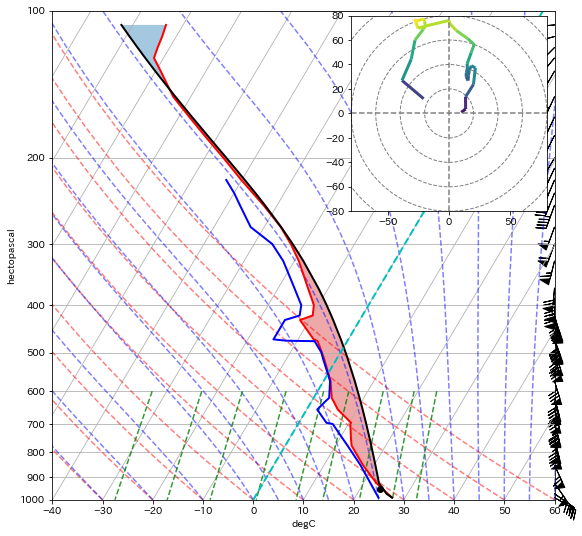

In [20]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'b', linewidth=2)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)